In [74]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [75]:
base_folder = "../outputs/TE_cnig_provincias/"
cases_fname = os.path.join(base_folder, "cases_pop_ds.nc")
risk_ij_fname = os.path.join(base_folder, "risk_ds.nc")

cases_ds = xr.load_dataset(cases_fname)
risk_ds = xr.load_dataset(risk_ij_fname)

risk_ij = risk_ds['risk_ij']
trips_ij = risk_ds['trips_ij']

risk_ij_dt = risk_ij.diff('date')
trips_ij_dt = trips_ij.diff('date')

cases_by_100k = cases_ds['new_cases_by_100k']
cases_by_100k_dt = cases_by_100k.diff('date')

dates = risk_ij_dt.coords['date']

## Testing for time series stationarirty

ADF is applied to each time serie $R_{i,j}(t)$ and $C_i(t)$ after applying first order differences on the time-series

Performing an augmented Dickey-Fuller test, with the following hypotheses:
* H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
* HA: The time series is stationary.



In [78]:
source = "28"
target = "33"

X = risk_ij_dt.loc[source, target, :].to_pandas()
Y = cases_by_100k_dt.loc[target, :].to_pandas()

provinces = cases_by_100k_dt.coords['id'].values

Rij_adf_p_vals = []
thr = 0.05
for x in provinces:
    for y in provinces:
        if x == y:
            continue
        result = adfuller(risk_ij.loc[x,y,:].values)
        pvalue = result[1]
        result_dt = adfuller(risk_ij_dt.loc[x,y,:].values)
        pvalue_dt = result_dt[1]
        Rij_adf_p_vals.append((x, y, pvalue, pvalue_dt))


df_Rij_ADF_p_vals = pd.DataFrame(data=Rij_adf_p_vals, columns=['source', 'target', 'pval', 'pval_dt'])

In [80]:
cases_adf_p_vals = []
thr = 0.05
for x in provinces:
    result = adfuller(cases_by_100k.loc[x,:].values)
    pvalue = result[1]

    result_dt = adfuller(cases_by_100k_dt.loc[x,:].values)
    pvalue_dt = result_dt[1]
    cases_adf_p_vals.append((x, pvalue, pvalue_dt))

df_cases_ADF_p_vals = pd.DataFrame(data=cases_adf_p_vals, columns=['source', 'pval', 'pval_dt'])

In [5]:
source = "28"
target = "19"

source = "08"
target = "07"

source = "28"
target = "33"

data = risk_ij_dt.values.flatten()
bins = np.quantile(data, [0.001, 0.05, 0.95, 0.999])
bins = np.quantile(data, [0.1, 0.2, 0.8, 0.9])
bins = [-2,-1,1,2]
X_risk_ij_dt = xr.apply_ufunc(my_digitize, risk_ij_dt, bins)

data = cases_by_100k_dt.values.flatten()
bins = np.quantile(data, [0.001, 0.2, 0.8, 0.999])
bins = np.quantile(data, [0.1, 0.2, 0.8, 0.9])
bins = [-2,-1,1,2]
Y_cases_by_100k_dt = xr.apply_ufunc(my_digitize, cases_by_100k_dt, bins)

d = 28
X = X_risk_ij_dt.loc[source, target, :].to_pandas()
Y = Y_cases_by_100k_dt.loc[target, :].to_pandas()
X = X[:-d]
Y = Y[d:]
print(f"TE  {source} -> {target}", transfer_entropy(X.values, Y.values, k=1))
print(f"ETE {source} -> {target}", effective_transfer_entropy(X.values, Y.values))

print()

X = X_risk_ij_dt.loc[target, source, :].to_pandas()
Y = Y_cases_by_100k_dt.loc[source, :].to_pandas()
X = X[:-d]
Y = Y[d:]
print(f"TE  {target} -> {source}", transfer_entropy(X.values, Y.values, k=1))
print(f"ETE {target} -> {source}", effective_transfer_entropy(X.values, Y.values))

TE  28 -> 33 0.0435266602474553
ETE 28 -> 33 0.01845166090837158

TE  33 -> 28 0.0
ETE 33 -> 28 0.0


TE  28 -> 33 0.0
ETE 28 -> 33 0.0
TE  33 -> 28 0.0
ETE 33 -> 28 0.0


ValueError: x and y must have same first dimension, but have shapes (407,) and (448,)

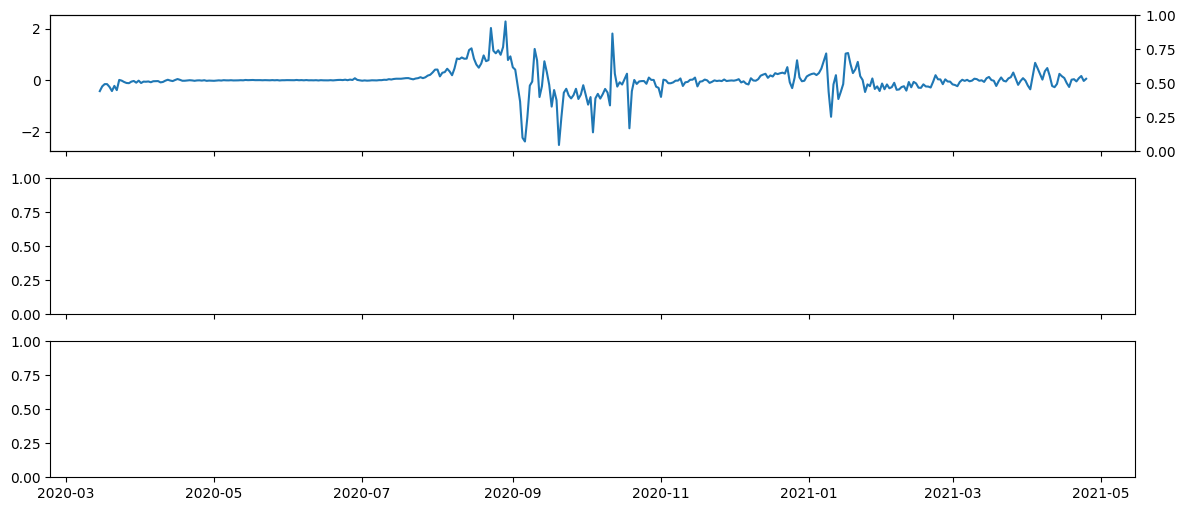

In [8]:
# Discretize based on quantiles
def kde_quantile_discretization(arr, n_quantiles=5):
    discretizer = KBinsDiscretizer(n_bins=n_quantiles, encode='ordinal', strategy='quantile')
    quantile_indices = discretizer.fit_transform(arr.reshape(-1, 1)).astype(int)
    return quantile_indices.ravel()

# X_enc = kde_quantile_discretization(X, n_quantiles=5)

# Apply the function across the last dimension
# discretized_data = xr.apply_ufunc(kde_quantile_discretization,
#                                   ds,
#                                   input_core_dims=[['dim_2']],
#                                   kwargs={'n_quantiles': 10},  # Set quantile number here
#                                   vectorize=True)



In [17]:
XX = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/X.nc")
YY = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/Y.nc")

A = XX.loc[source, target, :].values
B = X_risk_ij_dt.loc[source, target, :].values
print((A != B).sum())

A = YY.loc[target, :].values
B = Y_cases_by_100k_dt.loc[target, :].values
print((A != B).sum())


TE = xr.load_dataarray("../outputs/TE_cnig_provincias/run_ETE_w28_d14_S_Q1_-1_Q2_1_risk_ij/TE.nc")

# TE.loc[source, target, :].values

TE_xy

0
0


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
X = XX.loc[source, target, :].to_pandas().values
Y = YY.loc[target, :].to_pandas().values
print(f"TE  {source} -> {target}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {source} -> {target}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_xy = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_xy[TE_xy<0] = 0

X = XX.loc[target, source, :].to_pandas().values
Y = YY.loc[source, :].to_pandas().values
print(f"TE  {target} -> {source}", transfer_entropy(X[:-omega], Y[omega:], k=1))
print(f"ETE {target} -> {source}", effective_transfer_entropy(X[:-omega], Y[omega:]))

TE_yx = calculate_te(X, Y, omega=omega, delta=delta, ETE=use_ETE)
TE_yx[TE_yx<0] = 0

# start = int(omega)
# TE_dates = dates[start:]
# end = min(len(TE_dates), TE_xy.shape[0])
# TE_dates = TE_dates[:end]


# fig, axes = plt.subplots(3, 1, figsize=(14,6), sharex=True)
# axes[0].plot(risk_ij.loc[source, target, TE_dates].to_pandas())
# axes[0].plot(risk_ij.loc[target, source, TE_dates].to_pandas(), c='r')

# axes[1].plot(cases_by_100k.loc[source, TE_dates].to_pandas())
# axes[1].plot(cases_by_100k.loc[target, TE_dates].to_pandas(), c='r')


# DIxy = TE_xy - TE_yx
# # DIxy[np.abs(DIxy) < 1e-4] = 0
# axes[2].plot(TE_dates, DIxy)

# plt.show()

TE  28 -> 33 0.022727318412447302
ETE 28 -> 33 0.009798964154141923
TE  33 -> 28 0.0
ETE 33 -> 28 0.0
